In [178]:
import os
os.chdir(os.path.expanduser("~/Projects/zimmer"))
import copy
import pickle

import numpy as np
np.random.seed(1234)
from scipy.misc import logsumexp

import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("white")
seaborn.set_context("paper")
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter

from hips.plotting.colormaps import gradient_cmap
from hips.plotting.layout import create_axis_at_location

plt.ion()

from tqdm import tqdm
from functools import partial

from sklearn.decomposition import PCA

from zimmer.io import load_kato_data
import zimmer.plotting as zplt
from zimmer.observations import HierarchicalAutoRegressiveObservations,  HierarchicalRobustAutoRegressiveObservations
from zimmer.transitions import HierarchicalRecurrentTransitions, HierarchicalRecurrentOnlyTransitions
from zimmer.util import cached

from ssm.models import HMM
from ssm.core import _HMM
from ssm.init_state_distns import InitialStateDistribution
from ssm.transitions import RecurrentTransitions, InputDrivenTransitions, StationaryTransitions, \
    NeuralNetworkRecurrentTransitions, RecurrentOnlyTransitions
from ssm.observations import IndependentAutoRegressiveObservations

from ssm.util import find_permutation, compute_state_overlap
from ssm.preprocessing import pca_with_imputation, trend_filter, standardize

from pyhsmm.util.general import relabel_by_permutation, rle

In [2]:
# Specify hyperparameters
D = 10   # dimensionality of continuous latent states
M = 0   # dimensionality of input
results_dir = "results/kato/2018-10-09/D{}".format(D)
figures_dir = os.path.join(results_dir, "figures")

In [3]:
# Load the data
ys, ms, z_trues, z_true_key, neuron_names = load_kato_data(include_unnamed=False, signal="dff")
ys = [trend_filter(y) for y in ys]
# ys = [standardize(y, m) for y, m in zip(ys, ms)]

K_true = len(z_true_key)
N = ys[0].shape[1]
W = len(ys)
Ts = [y.shape[0] for y in ys]

Only including named neurons.
59 neurons across all 5 worms


In [4]:
with open(os.path.join("results", "kato", "2018-10-10", "summary.pkl"), "rb") as f:
    dim_reduction = pickle.load(f)
neuron_perm = dim_reduction["perm"]
# neuron_names = dim_reduction['neuron_names']
neuron_functions = dim_reduction['neuron_functions']
neuron_clusters = dim_reduction['neuron_clusters']
func_color_dict = dim_reduction['func_color_dict']
dividers = np.cumsum(np.bincount(neuron_clusters))[:-1]
                     

# Permute the true labels so that FWD and SLOW are adjacent

In [5]:
zimmer_perm = np.array([0, 1, 3, 2, 4, 5, 6, 7])
z_trues = [relabel_by_permutation(ztr, np.argsort(zimmer_perm)) for ztr in z_trues]
z_true_key = np.array(z_true_key)[zimmer_perm]

# PCA and ARHMMs

In [6]:
with open(os.path.join(results_dir, "pca.pkl"), "rb") as f:
    pca, xs = pickle.load(f)
xs = [x.copy('C') for x in xs]

In [7]:
# Load the best hierarchical HMM
with open(os.path.join(results_dir, "best_hhmm_recurrent_robust_ar.pkl"), "rb") as f:
    hhmm, _ = pickle.load(f)
    
hhmm.observations.tags_to_indices = dict([(i, i) for i in range(5)])
    
# Get the inferred states
z_infs = [hhmm.most_likely_states(x, tag=tag) for tag, x in enumerate(xs)]
hhmm.permute(find_permutation(np.concatenate(z_trues), np.concatenate(z_infs)))
z_infs = [hhmm.most_likely_states(x, tag=tag) for tag, x in enumerate(xs)]

In [8]:
# Load the best standard HMM
with open(os.path.join(results_dir, "best_hmm_recurrent_robust_ar.pkl"), "rb") as f:
    hmm, _ = pickle.load(f)
    
# Get the inferred states
hmm_z_infs = [hmm.most_likely_states(x, tag=tag) for tag, x in enumerate(xs)]
hmm.permute(find_permutation(np.concatenate(z_trues), np.concatenate(hmm_z_infs)))
hmm_z_infs = [hmm.most_likely_states(x, tag=tag) for tag, x in enumerate(xs)]

# Manually define a color scheme based on the neuron activations below

In [9]:
color_names = ["windows blue",
               "red",
               "crimson",
               "amber",
               "faded green",
               "orange",
               "clay",
               "dusty purple",
               "pink",
               "greyish",
               "mint",
               "light cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]

colors = seaborn.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

# Define a similarity measure on discrete states so that we can color code them accordingly

In [10]:
# import colorsys

# im = np.ones((300, 300, 3))
# radius = 150
# centre = 150, 150

# for x in range(300):
#     for y in range(300):
#         rx = x - centre[0]
#         ry = y - centre[1]
#         s = ((x - centre[0])**2.0 + (y - centre[1])**2.0)**0.5 / radius
#         if s <= 1.0:
#             h = ((np.arctan2(ry, rx) / math.pi) + 1.0) / 2.0
#             rgb = colorsys.hsv_to_rgb(h, s, 1.0)
#             im[x,y] = tuple([int(round(c*255.0)) for c in rgb])

# plt.imshow(im)

In [11]:
# def embed_hhmm_states(hhmm, D=2):
#     As = hhmm.observations.shared_As.reshape((hhmm.K, -1))
# #     bs = hhmm.observations.shared_bs.reshape((hhmm.K, -1))
# #     As = np.zeros((hhmm.K, 0))
#     bs = np.zeros((hhmm.K, 0))
#     # Rs = hhmm.transitions.shared_Rs.reshape((hhmm.K, -1))
#     Rs = np.zeros((hhmm.K, 0))
    
#     features = np.column_stack((As, bs, Rs))
#     embedding = PCA(D).fit_transform(features)
    
#     norm_embedding = (embedding + embedding.min()) / (embedding.max() - embedding.min())
#     norm_embedding -= norm_embedding.mean(0)
#     norm_embedding /= np.linalg.norm(norm_embedding, axis=1).max()
    
#     return norm_embedding

# hhmm_embedding = embed_hhmm_states(hhmm)

In [12]:
# import colorsys
# from hips.plotting.colormaps import gradient_cmap
# def embedding_to_colors(embedding):
#     K = embedding.shape[0]
#     assert embedding.shape[1] == 2
    
#     colors = np.zeros((K, 3))
#     for k in range(K):
#         rx, ry = embedding[k]
#         s = np.linalg.norm(embedding[k])
#         h = ((np.arctan2(ry, rx) / np.pi) + 1.0) / 2.0
#         colors[k] = colorsys.hsv_to_rgb(h, s, 1.0)
    
#     cmap = gradient_cmap(colors)
#     return colors, cmap

In [13]:
# hhmm_colors, hhmm_cmap = embedding_to_colors(hhmm_embedding)
# for k in range(hhmm.K):
#     plt.subplot(1, 2, 1)
#     plt.plot(hhmm_embedding[k, 0], hhmm_embedding[k, 1], 'o', ms=10, color=hhmm_colors[k])
    
#     plt.subplot(1, 2, 2)
#     plt.plot(hhmm_embedding[k, 0], hhmm_embedding[k, 1], 'o', ms=10, color=zplt.default_colors[k])

# Make Figure 1: Real data, continuous states, discrete states

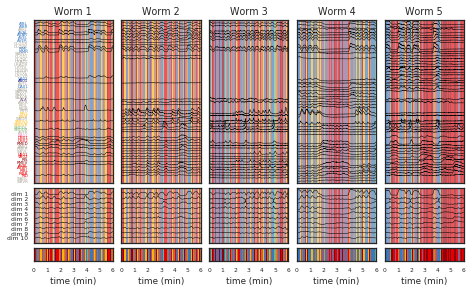

In [160]:
def make_figure_1(overlay=True, tmin=0, tmax=6, colors=colors, cmap=cmap):
    slc = slice(tmin*60*3, tmax*60*3+1)
    tslc = np.arange(tmin*60*3, tmax*60*3+1) / 3.0 / 60.

    # Make plot
    fig = plt.figure(figsize=(6.5, 4))
    fig.patch.set_alpha(0)
    gs = GridSpec(3, W, height_ratios=[12, 4, 1])

    for w in range(W):
        
        # Plot neural activity
        ax = fig.add_subplot(gs[0, w])
        
        if overlay:
            ax.imshow(z_infs[w][slc][None, :], 
                      vmin=0, vmax=len(colors)-1, cmap=cmap, 
                      aspect="auto", 
                      extent=(tmin, tmax, -N, 1), 
                      alpha=.66)
            
        yw = ys[w].copy()
        yw[~ms[w]] = np.nan
        ax.plot(tslc, yw[slc][:, neuron_perm] - np.arange(N), '-k', lw=0.5)
        if w == 0:
            ax.set_yticks(-np.arange(N))
            ax.set_yticklabels(neuron_names[neuron_perm], fontsize=4)
            # ax.set_ylabel("Observed $\Delta$ F/F")
            
            for tl, fn in zip(ax.yaxis.get_ticklabels(), neuron_functions[neuron_perm]):
                tl.set_color(func_color_dict[fn])
        else:
            ax.set_yticks([])
        ax.set_ylim(-N,1)
        ax.set_xlim(tmin, tmax)
        ax.set_xticks([])
        ax.set_title("Worm {}".format(w+1))

        # Plot continuous latent states
        ax = fig.add_subplot(gs[1, w])
        
        if overlay:
            ax.imshow(z_infs[w][slc][None, :], 
                      vmin=0, vmax=len(colors)-1, cmap=cmap, 
                      aspect="auto", 
                      extent=(tmin, tmax, -D, 1), 
                      alpha=.66)
            
        ax.plot(tslc, (xs[w][slc]  * 0.25 - np.arange(D)), '-k', lw=0.5)
        if w == 0:
            ax.set_yticks(np.arange(0, -D, -1))
            ax.set_yticklabels(["dim {}".format(d+1) for d in range(D)], fontsize=6)
            # ax.set_ylabel("Continuous States")
        else:
            ax.set_yticks([])
        ax.set_ylim(-D,1)

        ax.set_xlim(tmin, tmax)
        ax.set_xticks([])

        # Plot discrete latent states
        ax = fig.add_subplot(gs[2, w])
        ax.imshow(z_infs[w][slc][None, :], vmin=0, vmax=len(colors)-1, cmap=cmap, aspect="auto", extent=(tmin, tmax, 0, 1))
        ax.set_yticks([])
        ax.set_xticks(np.arange(tmin, tmax+1))
        ax.set_xticklabels(np.arange(tmin, tmax+1), fontsize=6)
        ax.set_xlabel("time (min)")

    plt.tight_layout(pad=0.5)

    figname = "1_data" if overlay else "1_data_white"
    plt.savefig(os.path.join(figures_dir, figname + ".pdf"))
    plt.savefig(os.path.join(figures_dir, figname + ".png"))

make_figure_1(overlay=True, colors=colors, cmap=cmap)
# make_figure_1(overlay=False)

# Make Figure 3: Discrete states

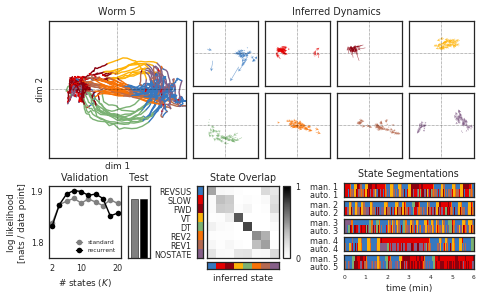

In [165]:
def make_figure_3(w=4, tmin=0, tmax=6):
    slc = slice(tmin*60*3, tmax*60*3+1)
    tslc = np.arange(tmin*60*3, tmax*60*3+1) / 3.0 / 60.
    
    # Precompute stuff
    z = z_infs[w]
    x = xs[w]
    cps = np.concatenate(([0], 1 + np.where(np.diff(z))[0], [z.size - 1]))
    
    # Compute normalized overlap
    K_zimmer = 8
    overlap = np.zeros((K_zimmer, hhmm.K), dtype=float)
    for ww in range(W):
        for k1 in range(K_zimmer):
            for k2 in range(hhmm.K):
                overlap[k1, k2] += np.sum((z_trues[ww] == k1) & (z_infs[ww] == k2))

    # Normalize the overlap from all worms and plot
    overlap /= overlap.sum(1)[:, None]


    # Make plot
    fig = plt.figure(figsize=(6.55, 4.1))
    fig.patch.set_alpha(0)
    
    # a. Plot the continuous latent states
    ax = create_axis_at_location(fig, .6 , 2, 1.9, 1.9, aspect="equal")
    ax.patch.set_alpha(0)
    for cp_start, cp_stop in zip(cps[:-1], cps[1:]):
        ax.plot(x[cp_start:cp_stop + 1, 0],
                x[cp_start:cp_stop + 1, 1],
                 '-', color=colors[z[cp_start]])        
    ax.plot([-3, 3], [0, 0], ':k', lw=0.5)
    ax.plot([0, 0], [-3, 3], ':k', lw=0.5)
    ax.set_xlim(-3, 3)
    ax.set_xlabel("dim {}".format(1))
    ax.set_xticks([])
    ax.set_ylim(-3, 3)
    ax.set_ylabel("dim {}".format(2))
    ax.set_yticks([])
    ax.set_title("Worm {}".format(w+1))
    
    # b. Plot the discrete dynamics
    qargs = dict(headwidth=7,
                 headlength=7,
                 alpha=0.75)

    for k in range(8):
        D = x.shape[1]
        ini = np.where(z == k)[0]
        if ini.size > 50:
            ini_inds = np.random.choice(ini.size, replace=False, size=50)
            ini = ini[ini_inds]

        Ak = hhmm.observations.As[w, k]
        bk = hhmm.observations.bs[w, k]
        dxdt = x.dot(Ak.T) + bk - x

        row, col = k // 4, k % 4
        ax = create_axis_at_location(fig, 2.6 + col,  2 + 1 - row, .9, .9, aspect="equal")
        ax.patch.set_alpha(0)
        ax.quiver(x[ini, 0], x[ini, 1], dxdt[ini, 0], dxdt[ini, 1],
                  color=colors[k], **qargs)

        ax.plot([-3, 3], [0, 0], ':k', lw=0.5)
        ax.plot([0, 0], [-3, 3], ':k', lw=0.5)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        
    dummyax = create_axis_at_location(fig, 2.6, 3, 4, .9)
    dummyax.set_xticks([])
    dummyax.set_yticks([])
    dummyax.patch.set_alpha(0)
    for sp in dummyax.spines.values():
        sp.set_visible(False)
    dummyax.set_title("Inferred Dynamics")
    
    # c1. Plot the validation likelihood
    ax = create_axis_at_location(fig, .6, .6, 1, 1)
    Ks = np.arange(2, 21, 2)
    D_val = 24890 # Size of validation data
    with open(os.path.join(results_dir, "hhmm_results.pkl"), "rb") as f:
        hhmm_results = pickle.load(f)
        
    std_val_lls = np.array([hhmm_results["hhmm_standard_robust_ar_K{}_eta1e-01".format(K)][2] for K in Ks])
    ax.plot(Ks, std_val_lls / D_val, '-o', color='gray', label="standard")
    rec_val_lls = np.array([hhmm_results["hhmm_recurrent_robust_ar_K{}_eta1e-01".format(K)][2] for K in Ks])
    ax.plot(Ks, rec_val_lls / D_val, '-o', color='black', label="recurrent")
            
    ax.legend(loc="lower right", ncol=1, fontsize=6, handlelength=1, columnspacing=.5, labelspacing=.5)        
    ax.set_ylim(44000 / D_val, 47500 / D_val)
    ax.set_yticks([1.8, 1.9])
    ax.set_xticks([2, 10, 20])
    ax.set_xlabel("# states ($K$)")
    ax.set_ylabel("log likelihood\n[nats / data point]")
    ax.set_title("Validation")
    

    # c2. Plot the test likelihood
    ax = create_axis_at_location(fig, 1.7, .6, .3, 1)
    D_test = 24790
    with open(os.path.join(results_dir, "best_results.pkl"), "rb") as f:
        best_results = pickle.load(f)
                
    ax.bar(0, best_results["best_hhmm_standard_robust_ar"][1] / D_test, width=.8, color='gray', edgecolor='k', linewidth=.5)
    ax.bar(1, best_results["best_hhmm_recurrent_robust_ar"][1] / D_test, width=.8, color='black', edgecolor='k', linewidth=.5)
    ax.set_ylim(44000 / D_val, 47500 / D_val)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-.75, 1.75)
    ax.set_title("Test")
    
    # d. Plot the state overlap    
    ax1 = create_axis_at_location(fig, 2.8, .6, 1, 1)
    im = ax1.imshow(overlap, vmin=0, vmax=1.0, cmap="Greys", interpolation="nearest", aspect="equal")
    ax1.set_yticks([])
    ax1.set_xticks([])
    ax1.set_title("State Overlap")

    lax = create_axis_at_location(fig, 2.65, .6, .1, 1)
    lax.imshow(np.arange(K_zimmer)[:, None], cmap=cmap, 
                  vmin=0, vmax=len(colors) - 1, aspect=1.5)
    
    lax.set_xticks([])
    lax.set_yticks(np.arange(K_zimmer))
    lax.set_yticklabels(z_true_key, fontsize=8)

    # bax = fig.add_subplot(gs[35, 25:35])
    bax = create_axis_at_location(fig, 2.8, .45, 1, .1)
    bax.imshow(np.arange(hhmm.K)[None, :], cmap=cmap,  aspect="auto",
               vmin=0, vmax=len(colors)-1)
    bax.set_xticks([])
    bax.set_yticks([])
    bax.set_xlabel("inferred state")

    # axcb = fig.add_subplot(gs[24:34, 36])
    axcb = create_axis_at_location(fig, 3.85, .6, .1, 1)
    plt.colorbar(im, cax=axcb, ticks=[0, 1])
    
    # e. Plot the manual and inferred state segmentations
    for ww in range(W):
        # ax = fig.add_subplot(gs[24+ww*2:24+ww*2+2, 46:62])
        # ax = create_axis_at_location(fig, 4.6, 1.95 - .25 * ww , 1.8, .2)
        ax = create_axis_at_location(fig, 4.7, .45 + .25 * (W-ww-1), 1.8, .2)
        ax.imshow(z_trues[ww][slc][None, :],
                  cmap=cmap, 
                  vmin=0, vmax=len(colors) - 1, 
                  extent=(tmin, tmax, 1, 2),
                  aspect="auto")
        ax.imshow(z_infs[ww][slc][None, :],
                  cmap=cmap, 
                  vmin=0, vmax=len(colors) - 1, 
                  extent=(tmin, tmax, 0, 1),
                  aspect="auto")
        ax.set_xticks([])
        ax.set_yticks([1.5, .5])
        ax.set_ylim(0, 2)
        ax.set_yticklabels(["man. {}".format(ww+1), "auto. {}".format(ww+1)], fontsize=8)

        if ww == W-1:
            ax.set_xticks(np.arange(tmin, tmax+1))
            ax.set_xticklabels(np.arange(tmin, tmax+1), fontsize=6)
            ax.set_xlabel("time (min)")
            
        if ww == 0:
            ax.set_title("State Segmentations")
            
    
    figname = "3_syllables"
    plt.savefig(os.path.join(figures_dir, figname + ".pdf"))
    plt.savefig(os.path.join(figures_dir, figname + ".png"))

make_figure_3(w=4)


# Supplement Figure 3: compare manual and inferred states

In [256]:
# Compare inferred states to basic kmeans clustering
from sklearn.cluster import KMeans

dxs = [np.gradient(x, axis=0) for x in xs]
dxs = standardize(np.vstack(dxs), np.ones_like(np.vstack(dxs), dtype=bool))
dxs = np.split(dxs, np.cumsum(Ts)[:-1])

# KMeans per worm
z_kmeans_per_worm = []
for w in range(W):
    km = KMeans(8).fit(np.hstack((xs[w], dxs[w])))
    zz = km.labels_.astype(int)
    perm = find_permutation(z_trues[w], zz)
    z_kmeans_per_worm.append(relabel_by_permutation(zz, np.argsort(perm)))
    
# KMeans on states and derivatives
km = KMeans(8).fit(np.hstack((np.vstack(xs), np.vstack(dxs))))
z_kmeans = np.split(km.labels_.astype(int), np.cumsum(Ts)[:-1])
perm_kmeans = find_permutation(np.concatenate(z_trues), np.concatenate(z_kmeans))
z_kmeans = [relabel_by_permutation(zz, np.argsort(perm_kmeans)) for zz in z_kmeans]

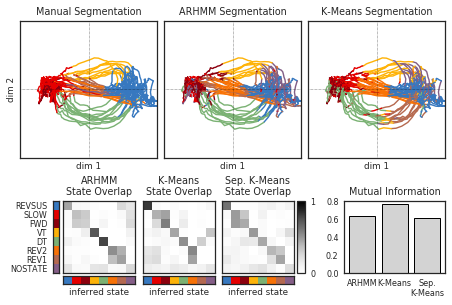

In [261]:
def make_supp_figure_3(w=4, tmin=0, tmax=6):
    x = xs[w]
    
    # Compute normalized overlap
    K_zimmer = 8
    kmeans_overlap = np.zeros((K_zimmer, km.n_clusters), dtype=float)
    for ww in range(W):
        for k1 in range(K_zimmer):
            for k2 in range(hhmm.K):
                kmeans_overlap[k1, k2] += np.sum((z_trues[ww] == k1) & (z_kmeans[ww] == k2))

    # Normalize the overlap from all worms and plot
    kmeans_overlap /= kmeans_overlap.sum(1)[:, None]
    
    kmeans_per_worm_overlap = np.zeros((K_zimmer, km.n_clusters), dtype=float)
    for ww in range(W):
        for k1 in range(K_zimmer):
            for k2 in range(hhmm.K):
                kmeans_per_worm_overlap[k1, k2] += np.sum((z_trues[ww] == k1) & (z_kmeans_per_worm[ww] == k2))

    # Normalize the overlap from all worms and plot
    kmeans_per_worm_overlap /= kmeans_per_worm_overlap.sum(1)[:, None]
    
    
    hhmm_overlap = np.zeros((K_zimmer, hhmm.K), dtype=float)
    for ww in range(W):
        for k1 in range(K_zimmer):
            for k2 in range(hhmm.K):
                hhmm_overlap[k1, k2] += np.sum((z_trues[ww] == k1) & (z_infs[ww] == k2))

    # Normalize the overlap from all worms and plot
    hhmm_overlap /= hhmm_overlap.sum(1)[:, None]

    # Make plot
    fig = plt.figure(figsize=(6.55, 4.3))
    fig.patch.set_alpha(0)
    
    # a. Plot the manually labeled trajectory
    z = z_trues[w]
    cps = np.concatenate(([0], 1 + np.where(np.diff(z))[0], [z.size - 1]))

    ax = create_axis_at_location(fig, .6 , 2.2, 1.9, 1.9, aspect="equal")
    ax.patch.set_alpha(0)
    for cp_start, cp_stop in zip(cps[:-1], cps[1:]):
        ax.plot(x[cp_start:cp_stop + 1, 0],
                x[cp_start:cp_stop + 1, 1],
                 '-', color=colors[z[cp_start]])        
    ax.plot([-3, 3], [0, 0], ':k', lw=0.5)
    ax.plot([0, 0], [-3, 3], ':k', lw=0.5)
    ax.set_xlim(-3, 3)
    ax.set_xlabel("dim {}".format(1))
    ax.set_xticks([])
    ax.set_ylim(-3, 3)
    ax.set_ylabel("dim {}".format(2))
    ax.set_yticks([])
    ax.set_title("Manual Segmentation")

    # b. Plot the inferred trajectory
    z = z_infs[w]
    cps = np.concatenate(([0], 1 + np.where(np.diff(z))[0], [z.size - 1]))

    ax = create_axis_at_location(fig, 2.6 , 2.2, 1.9, 1.9, aspect="equal")
    ax.patch.set_alpha(0)
    for cp_start, cp_stop in zip(cps[:-1], cps[1:]):
        ax.plot(x[cp_start:cp_stop + 1, 0],
                x[cp_start:cp_stop + 1, 1],
                 '-', color=colors[z[cp_start]])        
    ax.plot([-3, 3], [0, 0], ':k', lw=0.5)
    ax.plot([0, 0], [-3, 3], ':k', lw=0.5)
    ax.set_xlim(-3, 3)
    ax.set_xlabel("dim {}".format(1))
    ax.set_xticks([])
    ax.set_ylim(-3, 3)
    ax.set_yticks([])
    ax.set_title("ARHMM Segmentation")

    # c. Plot the continuous latent states
    z = z_kmeans[w]
    cps = np.concatenate(([0], 1 + np.where(np.diff(z))[0], [z.size - 1]))

    ax = create_axis_at_location(fig, 4.6 , 2.2, 1.9, 1.9, aspect="equal")
    ax.patch.set_alpha(0)
    for cp_start, cp_stop in zip(cps[:-1], cps[1:]):
        ax.plot(x[cp_start:cp_stop + 1, 0],
                x[cp_start:cp_stop + 1, 1],
                 '-', color=colors[z[cp_start]])        
    ax.plot([-3, 3], [0, 0], ':k', lw=0.5)
    ax.plot([0, 0], [-3, 3], ':k', lw=0.5)
    ax.set_xlim(-3, 3)
    ax.set_xlabel("dim {}".format(1))
    ax.set_xticks([])
    ax.set_ylim(-3, 3)
    ax.set_yticks([])
    ax.set_title("K-Means Segmentation")

    # d. hrARHMM state overlap    
    ax1 = create_axis_at_location(fig, 1.2, .6, 1, 1)
    im = ax1.imshow(hhmm_overlap, vmin=0, vmax=1.0, cmap="Greys", interpolation="nearest", aspect="equal")
    ax1.set_yticks([])
    ax1.set_xticks([])
    ax1.set_title("ARHMM\nState Overlap")

    lax = create_axis_at_location(fig, 1.05, .6, .1, 1)
    lax.imshow(np.arange(K_zimmer)[:, None], cmap=cmap, 
                  vmin=0, vmax=len(colors) - 1, aspect=1.5)
    
    lax.set_xticks([])
    lax.set_yticks(np.arange(K_zimmer))
    lax.set_yticklabels(z_true_key, fontsize=8)

    # bax = fig.add_subplot(gs[35, 25:35])
    bax = create_axis_at_location(fig, 1.2, .45, 1, .1)
    bax.imshow(np.arange(hhmm.K)[None, :], cmap=cmap,  aspect="auto",
               vmin=0, vmax=len(colors)-1)
    bax.set_xticks([])
    bax.set_yticks([])
    bax.set_xlabel("inferred state")
    
    # d. KMeans overlap
    ax1 = create_axis_at_location(fig, 2.3, .6, 1, 1)
    im = ax1.imshow(kmeans_overlap, vmin=0, vmax=1.0, cmap="Greys", interpolation="nearest", aspect="equal")
    ax1.set_yticks([])
    ax1.set_xticks([])
    ax1.set_title("K-Means\nState Overlap")

    # bax = fig.add_subplot(gs[35, 25:35])
    bax = create_axis_at_location(fig, 2.3, .45, 1, .1)
    bax.imshow(np.arange(hhmm.K)[None, :], cmap=cmap,  aspect="auto",
               vmin=0, vmax=len(colors)-1)
    bax.set_xticks([])
    bax.set_yticks([])
    bax.set_xlabel("inferred state")
    
    # d. KMeans (perm worm) overlap
    ax1 = create_axis_at_location(fig, 3.4, .6, 1, 1)
    im = ax1.imshow(kmeans_per_worm_overlap, vmin=0, vmax=1.0, cmap="Greys", interpolation="nearest", aspect="equal")
    ax1.set_yticks([])
    ax1.set_xticks([])
    ax1.set_title("Sep. K-Means\nState Overlap")

    # bax = fig.add_subplot(gs[35, 25:35])
    bax = create_axis_at_location(fig, 3.4, .45, 1, .1)
    bax.imshow(np.arange(hhmm.K)[None, :], cmap=cmap,  aspect="auto",
               vmin=0, vmax=len(colors)-1)
    bax.set_xticks([])
    bax.set_yticks([])
    bax.set_xlabel("inferred state")

    # axcb = fig.add_subplot(gs[24:34, 36])
    axcb = create_axis_at_location(fig, 4.45, .6, .1, 1)
    plt.colorbar(im, cax=axcb, ticks=[0, 1])
    
    # Plot the clustering score for each case
    from sklearn.metrics import jaccard_similarity_score, adjusted_mutual_info_score, mutual_info_score, adjusted_rand_score
    score = mutual_info_score
    ax = create_axis_at_location(fig, 5.1, .6, 1.4, 1)
    ax.bar(1, score(np.concatenate(z_trues), np.concatenate(z_infs)), color='lightgray', lw=1, edgecolor='k')
    ax.bar(2, score(np.concatenate(z_trues), np.concatenate(z_kmeans)), color='lightgray', lw=1, edgecolor='k')
    ax.bar(3, score(np.concatenate(z_trues), np.concatenate(z_kmeans_per_worm)), color='lightgray', lw=1, edgecolor='k')
#     ax.set_ylim(.4, .5)
#     ax.set_yticks([.4, .5])
    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(["ARHMM", "K-Means", "Sep.\nK-Means"], fontsize=8)
    ax.set_title("Mutual Information")
    
    figname = "s3_stateoverlap"
    plt.savefig(os.path.join(figures_dir, figname + ".pdf"))
    plt.savefig(os.path.join(figures_dir, figname + ".png"))

make_supp_figure_3(w=4)


# Figure 4: States driving clusters of neurons 

Compute the average (change in) activation of neurons in different segmentations.

In [167]:
y_all = np.vstack(ys)
m_all = np.vstack(ms)
y_all[~m_all] = np.nan
z_all = np.concatenate(z_infs)

# Compute average activity of neurons in each discrete state
y_avg = np.zeros((hhmm.K, N))
for k in range(hhmm.K):
    y_avg[k] = np.nanmean(y_all[z_all == k], axis=0)

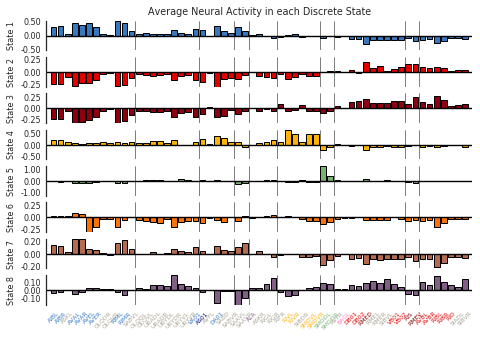

In [172]:
plt.figure(figsize=(6.5, 4.5))
for k in range(hhmm.K):
    yl = 1.0 * abs(y_avg[k]).max()

    ax = plt.subplot(hhmm.K, 1, k+1)
    ax.patch.set_alpha(0)
    if k == 0:
        ax.set_title("Average Neural Activity in each Discrete State")
    
    plt.bar(np.arange(N), y_avg[k][neuron_perm], width=0.8, color=colors[k], edgecolor=['k'] * N, linewidth=1)
    plt.plot([-1, N], [0, 0], '-k')
    
    for div in dividers:
        plt.plot([div -.5, div - .5], [-yl, yl], '-k', lw=0.5)
        
    plt.xlim(-1, N)
    plt.ylim(-yl, yl)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    if k == hhmm.K - 1:
        plt.xticks(np.arange(N), neuron_names[neuron_perm], rotation=45, fontsize=6)
        for tl, fn in zip(ax.xaxis.get_ticklabels(), neuron_functions[neuron_perm]):
            tl.set_color(func_color_dict[fn])

    else:
        plt.xticks([])
        
    plt.ylabel("State {}".format(k+1), fontsize=8)
    
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
plt.tight_layout(pad=0.05)
    
figname = "4_activations"
plt.savefig(os.path.join(figures_dir, figname + ".pdf"))
plt.savefig(os.path.join(figures_dir, figname + ".png"), dpi=300)

In [24]:
# Compute the average change in activity
dy_avg = np.zeros((hhmm.K, N))
counts = np.zeros((hhmm.K, N))
for y, m, z in zip(ys, ms, z_infs):
    assert np.allclose(y[~m], 0)
    
    states, durs = rle(z)
    starts = np.concatenate(([0], np.cumsum(durs)[:-1]))
    stops = np.cumsum(durs) - 1
    
    for k in range(hhmm.K):
        inds = (states == k)
        counts[k] += np.sum(m[stops[inds]], axis=0)
        dy_avg[k] += np.sum(y[stops[inds]] - y[starts[inds]], axis=0)
        
dy_avg /= counts

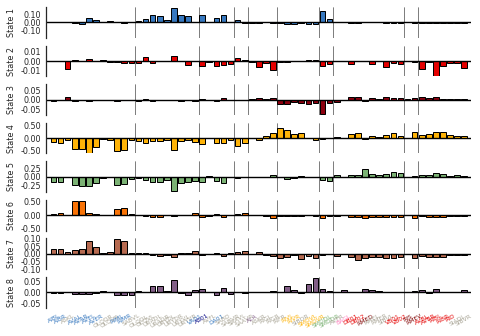

In [85]:
plt.figure(figsize=(6.5, 4.5))
for k in range(hhmm.K):
    yl = 1.05 * abs(dy_avg[k]).max()
    ax = plt.subplot(hhmm.K, 1, k+1)
    
    plt.bar(np.arange(N), dy_avg[k][neuron_perm], width=0.8, color=colors[k], edgecolor=['k'] * N, linewidth=1)
    plt.plot([-1, N], [0, 0], '-k')
    
    for div in dividers:
        plt.plot([div -.5, div - .5], [-yl, yl], '-k', lw=0.5)
        
    plt.xlim(-1, N)
    plt.ylim(-yl, yl)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    if k == hhmm.K - 1:
        plt.xticks(np.arange(N), neuron_names[neuron_perm], rotation=30, fontsize=6)
        for tl, fn in zip(ax.xaxis.get_ticklabels(), neuron_functions[neuron_perm]):
            tl.set_color(func_color_dict[fn])

    else:
        plt.xticks([])
        
    plt.ylabel("State {}".format(k+1), fontsize=8)
    
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)

plt.tight_layout(pad=0.05)

figname = "s4_delta_activations"
plt.savefig(os.path.join(figures_dir, figname + ".pdf"))
plt.savefig(os.path.join(figures_dir, figname + ".png"), dpi=300)

# Figure 5: Hierarchical modeling

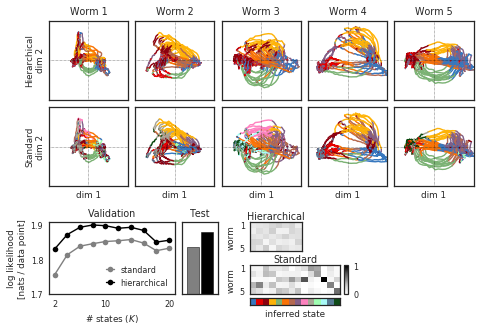

In [176]:
def make_figure_3(inds=(0, 1)):
    
    # Make plot
    fig = plt.figure(figsize=(6.5, 4.5))
    fig.patch.set_alpha(0)

    
    # Subplots 6in / 5 = 1.2in wide; .1 space = 1.1 inch wide
    for row, (name, zs) in enumerate(zip(["Hierarchical", "Standard"], [z_infs, hmm_z_infs])):
        for w in range(W):
            z = zs[w]
            x = xs[w]
            cps = np.concatenate(([0], 1 + np.where(np.diff(z))[0], [z.size - 1]))

            # Make plot
            # ax = fig.add_subplot(gs[row, w*2:(w+1)*2], aspect="equal")
            ax = create_axis_at_location(fig, .6 + 1.2 * w, 2.0 + 1.2 * (1 - row), 1.1, 1.1)
            ax.patch.set_alpha(0)

            # Color denotes our inferred latent discrete state
            for cp_start, cp_stop in zip(cps[:-1], cps[1:]):
                ax.plot(x[cp_start:cp_stop + 1, inds[0]],
                        x[cp_start:cp_stop + 1, inds[1]],
                         '-', color=colors[min(z[cp_start], len(colors)-1)])

            ax.plot([-3, 3], [0, 0], ':k', lw=0.5)
            ax.plot([0, 0], [-3, 3], ':k', lw=0.5)        
            ax.set_xlim(-3, 3)
            if row == 1:
                ax.set_xlabel("dim {}".format(inds[0] + 1))
            ax.set_xticks([])
            ax.set_ylim(-3, 3)
            if w == 0:
                ax.set_ylabel(name+"\ndim {}".format(inds[1] + 1))
            ax.set_yticks([])
            
            if row == 0:
                ax.set_title("Worm {}".format(w+1))
        
    # Plot the likelihoods
    ax = create_axis_at_location(fig, .6, .5, 1.75, 1.0)
    Ks = np.arange(2, 21, 2)
    D_val = 24890 # Size of validation data
    with open(os.path.join(results_dir, "hmm_results.pkl"), "rb") as f:
        hmm_results = pickle.load(f)

    with open(os.path.join(results_dir, "hhmm_results.pkl"), "rb") as f:
        hhmm_results = pickle.load(f)

    std_val_lls = np.array([hmm_results["hmm_recurrent_robust_ar_K{}".format(K)][2] for K in Ks])
    ax.plot(Ks, std_val_lls / D_val, '-o', color='gray', label="standard")
    hier_val_lls = np.array([hhmm_results["hhmm_recurrent_robust_ar_K{}_eta1e-01".format(K)][2] for K in Ks])
    ax.plot(Ks, hier_val_lls / D_val, '-o', color='black', label="hierarchical")

    ax.legend(loc="lower right", ncol=1, fontsize=8, handlelength=1, columnspacing=.5, labelspacing=.5)        
    ax.set_ylim(42700 / D_val, 47500 / D_val)
    ax.set_xticks([2, 10, 20])
    ax.set_xlabel("# states ($K$)")
    ax.set_yticks([1.7, 1.8, 1.9])
    ax.set_ylabel("log likelihood\n[nats / data point]")
    ax.set_title("Validation")
        
    # c2. Plot the test likelihood
    ax = create_axis_at_location(fig, 2.45, .5, .5, 1.0)
    D_test = 24790
    with open(os.path.join(results_dir, "best_results.pkl"), "rb") as f:
        best_results = pickle.load(f)
                
    ax.bar(0, best_results["best_hmm_recurrent_robust_ar"][1] / D_test, width=.8, color='gray', edgecolor='k', linewidth=.5)
    ax.bar(1, best_results["best_hhmm_recurrent_robust_ar"][1] / D_test, width=.8, color='black', edgecolor='k', linewidth=.5)
    ax.set_ylim(42700 / D_val, 47500 / D_val)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-.75, 1.75)
    ax.set_title("Test")

    # Plot the state usage
    ax = create_axis_at_location(fig, 3.4, 1.1, 1.25 * hhmm.K / hmm.K, .4)
    hier_usage = np.array([np.bincount(zi, minlength=hhmm.K) for zi in z_infs]).astype(float)
    hier_usage /= hier_usage.sum(axis=0, keepdims=True)
    plt.imshow(hier_usage, vmin=0, vmax=1, cmap="Greys", aspect="auto")
    plt.xticks([])
    plt.yticks([0, 4], [1, 5])
    plt.ylabel("worm")
    plt.title("Hierarchical", y=0.9)

    ax = create_axis_at_location(fig, 3.4, .5, 1.25, .4)
    std_usage = np.array([np.bincount(zi, minlength=hmm.K) for zi in hmm_z_infs]).astype(float)
    std_usage /= std_usage.sum(axis=0, keepdims=True)
    im = plt.imshow(std_usage, vmin=0, vmax=1, cmap="Greys", aspect="auto")
    plt.xticks([])
    plt.yticks([0, 4], [1, 5])
    plt.ylabel("worm")
    plt.title("Standard", y=0.9)
    
    bax = create_axis_at_location(fig, 3.4, .35, 1.25, .1)
    bax.imshow(np.arange(hmm.K)[None, :], cmap=cmap,  aspect="auto", vmin=0, vmax=len(colors)-1)
    bax.set_xticks([])
    bax.set_yticks([])
    bax.set_xlabel("inferred state")
    
    cbax = create_axis_at_location(fig, 4.7, .5, 0.05, .4)
    plt.colorbar(im, cbax, ticks=[0, 1])
    
    figname = "5_hierarchy"
    plt.savefig(os.path.join(figures_dir, figname + ".pdf"))
    plt.savefig(os.path.join(figures_dir, figname + ".png"))

make_figure_3()

# Figure 6: Recurrence and non-Markovianity

In [175]:
# # Load simulations and permute appropriately
# # with open(os.path.join(results_dir, "sim", "best_hhmm_standard_robust_ar_sim.pkl"), "rb") as f:
# #     std_sims = pickle.load(f)

# with open(os.path.join(results_dir, "sim", "best_hhmm_recurrent_robust_ar_sim.pkl"), "rb") as f:
#     rec_sims = pickle.load(f)

# def compute_post_duration_distributions(z_infs, K, maxdur, binw=3, mindur=0):
#     bins = np.arange(1, maxdur, binw)
#     durations = np.zeros((K, len(bins)-1))
#     for w in range(W):
#         states, durs = rle(z_infs[w])
#         for k in range(K):
#             inds = (states == k) & (durs > mindur)
#             durations[k] += np.histogram(durs[inds], bins)[0]

#     durations /= durations.sum(1, keepdims=True)
#     return durations, bins

# def compute_sim_duration_distributions(sims, K, maxdur, binw=3, mindur=0):
#     bins = np.arange(1, maxdur, binw)
#     durations = np.zeros((K, len(bins)-1))
#     for w in range(W):
#         for z, _, _ in sims[w]:
#             z = relabel_by_permutation(z, np.argsort(np.concatenate((zimmer_perm, np.arange(8, K)))))
#             states, durs = rle(z)
#             for k in range(K):
#                 inds = (states == k) & (durs > mindur)
#                 durations[k] += np.histogram(durs[inds], bins)[0]

#     durations /= (durations.sum(1, keepdims=True) + 1e-8)
#     return durations, bins

# def fit_geometric_to_durs(z_infs, K, maxdur, binw=3):
#     assert maxdur % binw == 0
#     mean_durs = np.zeros(K)
#     counts = np.zeros(K)
#     for w in range(W):
#         states, durs = rle(z_infs[w])
#         for k in range(K):
#             mean_durs[k] += np.sum(durs[states == k])
#             counts[k] += np.sum(states == k)
#     mean_durs /= counts
#     ps = 1./mean_durs

#     # Compute geometric probability for each bin
#     bins = np.arange(1, maxdur)
#     pmf = (1-ps[:, None])**(bins[None, :]) * ps[:, None]
#     pmf = pmf.reshape((K, -1, binw)).sum(-1)
#     return pmf

# maxdur = 45
# binw = 1
# post_durations, bins = compute_post_duration_distributions(z_infs, 8, maxdur, binw)
# rec_durations, _ = compute_sim_duration_distributions(rec_sims, 8, maxdur, binw)
# geom_durations = fit_geometric_to_durs(z_infs, 8, maxdur, binw)

# fig = plt.figure(figsize=(6.5, 4))
# ax = create_axis_at_location(.5, .5, 2.5, 2.5)
# zplt.plo

# # for k in range(8):
# #     plt.figure()
# #     plt.bar(bins[:-1], rec_durations[k], width=binw, color=colors[k])
# #     plt.plot(bins, geom_durations[k], ':k')
# #     plt.plot(bins[:-1], post_durations[k], '-k')
    

/home/scott/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
/home/scott/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.


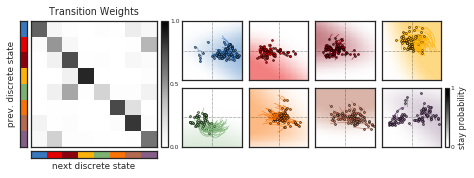

In [177]:
from scipy.misc import logsumexp
    
w_to_plot = 1
    
def plot_trans_probs(ax, k, hhmm, z_infs, xs, xlim=(-3, 3), ylim=(-3, 3), n_pts=50):
    K = hhmm.K

    XX, YY = np.meshgrid(np.linspace(*xlim, n_pts),
                         np.linspace(*ylim, n_pts))
    xy = np.column_stack((np.ravel(XX), np.ravel(YY)))
    
#     r = hhmm.transitions.shared_log_Ps[k]
#     R = hhmm.transitions.shared_Rs[:, :2]
    r = hhmm.transitions.log_Ps[w_to_plot, k]
    R = hhmm.transitions.Rs[w_to_plot, :, :2]

    lp = xy.dot(R.T) + r
    lp -= logsumexp(lp, axis=1, keepdims=True)
    prs = np.exp(lp)

    start = np.array([1., 1., 1., 0.])
    end = np.concatenate((colors[k % len(colors)], [0.5]))
    cmap = gradient_cmap([start, start, end, end], bounds=[0, .1, .9, 1])
    # cmap = gradient_cmap([start, end])
    im = ax.imshow(prs[:, k].reshape(*XX.shape),
                   extent=xlim + tuple(reversed(ylim)),
                   vmin=0, vmax=1, cmap=cmap)

    # Plot instances of the trajectory
    for z, x in zip(z_infs, xs):
        states, durs = rle(z)
        starts = np.concatenate(([0], np.cumsum(durs[:-1])))
        inds = np.where((states == k) & (durs > 2))[0]
        choices = np.random.choice(inds, size=min(20, len(inds)), replace=False)
        for ts, d in zip(starts[choices], durs[choices]):
            ax.plot(x[ts:ts+d, 0], x[ts:ts+d, 1], '-', lw=.5, color=colors[k])
        for ts, d in zip(starts[choices], durs[choices]):
            ax.plot(x[ts+d-1, 0], x[ts+d-1, 1], 'o', ms=2, mec='k', mew=.5, mfc=colors[k], alpha=0.9)

    # Plot the hyperplane (defined by the set of points orthogonal to R[k])
    # (x, y) \dot (R1, R2) + rk = 0
    # R2 * y + R1 * x + rk = 0
    # y = - (R1 * x + rk) / R2
#         xx = np.linspace(-3, 3, 50)
#         yy = -(R[k, 0] * xx + r[k]) / R[k, 1] 
#         plt.plot(xx, yy, '-', lw=2, color=colors[k])

    ax.plot([0, 0], ylim, ':k', lw=.5)
    ax.plot(xlim, [0, 0], ':k', lw=.5)

    ax.set_xticks([])
    ax.set_xlim(xlim)
    ax.set_yticks([])
    ax.set_ylim(ylim)
    return im

fig = plt.figure(figsize=(6.5, 2.5))
ax = create_axis_at_location(fig, .4, .4, 1.75, 1.75)
log_P = hhmm.transitions.log_Ps[w_to_plot]
P = np.exp(log_P - logsumexp(log_P, axis=1, keepdims=True))
im = ax.imshow(P, vmin=0, vmax=1, cmap="Greys")
# im = ax.imshow(log_P - logsumexp(log_P, axis=1, keepdims=True), cmap="Greys")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Transition Weights")

lax = create_axis_at_location(fig, .25, .4, .1, 1.75)
lax.imshow(np.arange(hhmm.K)[:, None], cmap=cmap, vmin=0, vmax=len(colors)-1, aspect="auto")
lax.set_xticks([])
lax.set_yticks([])
lax.set_ylabel("prev. discrete state")

bax = create_axis_at_location(fig, .4, .25, 1.75, .1)
bax.imshow(np.arange(hhmm.K)[None, :], cmap=cmap, vmin=0, vmax=len(colors)-1, aspect="auto")
bax.set_xticks([])
bax.set_yticks([])
bax.set_xlabel("next discrete state")

cax = create_axis_at_location(fig, 2.2, .4, .1, 1.75)
plt.colorbar(im, cax=cax, ticks=[0, 0.5, 1])
# plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=6, pad=2)

for k in range(4):
    ax = create_axis_at_location(fig, 2.5 + k * .925, 1.325, .825, .825)
    plot_trans_probs(ax, k, hhmm, z_infs, xs)
    
for k in range(4, 8):
    ax = create_axis_at_location(fig, 2.5 + (k - 4) * .925, .4, .825, .825)
    plot_trans_probs(ax, k, hhmm, z_infs, xs)

dummyax = create_axis_at_location(fig, 0, 0, 0, 0)
dummyax.set_visible(False)
dummycmap = gradient_cmap([np.ones(3), np.ones(3), np.zeros(3), np.zeros(3)], bounds=[0, .1, .9, 1])
dummyim = dummyax.imshow(np.random.randn(2, 2), vmin=0, vmax=1, cmap=dummycmap)
cax = create_axis_at_location(fig, 2.5 + 4 * .925 - .05, .4, .05, .825)
plt.colorbar(dummyim, cax=cax, ticks=[0, 1])
cax.tick_params(labelsize=6, pad=2)
cax.set_ylabel("stay probability", fontsize=8)

figname = "6_transitions"
plt.savefig(os.path.join(figures_dir, figname + ".pdf"))
plt.savefig(os.path.join(figures_dir, figname + ".png"), dpi=300)

# Figure 7: Input driven models

# Figure 8: Simulations

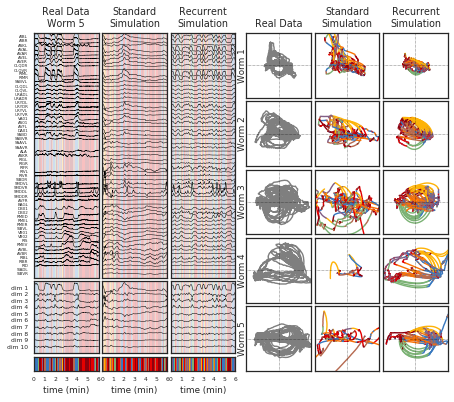

In [158]:
def make_figure_5(w, s=0, tmin=0, tmax=6):

    # Make plot
    fig = plt.figure(figsize=(6.55, 5.6))
    fig.patch.set_alpha(0)

    # Load simulations and permute appropriately
    with open(os.path.join(results_dir, "sim", "best_hhmm_standard_robust_ar_sim.pkl"), "rb") as f:
        std_sims = pickle.load(f)
        std_z_sim, std_x_sim, std_y_sim = std_sims[w][s]
        std_perm = np.concatenate((zimmer_perm, np.arange(8, std_z_sim.max())))
        std_z_sim = relabel_by_permutation(std_z_sim, np.argsort(std_perm))
        

    with open(os.path.join(results_dir, "sim", "best_hhmm_recurrent_robust_ar_sim.pkl"), "rb") as f:
        rec_sims = pickle.load(f)
        rec_z_sim, rec_x_sim, rec_y_sim = rec_sims[w][s]
        rec_perm = np.concatenate((zimmer_perm, np.arange(8, rec_z_sim.max())))
        rec_z_sim = relabel_by_permutation(rec_z_sim, np.argsort(rec_perm))
    
    # Permute the simulations 
    
    datas = [(z_infs[w], xs[w], ys[w], ms[w], "Real Data\nWorm {}".format(w+1)),
             (std_z_sim, std_x_sim, std_y_sim, np.ones_like(std_y_sim), "Standard\nSimulation"),
             (rec_z_sim, rec_x_sim, rec_y_sim, np.ones_like(rec_y_sim), "Recurrent\nSimulation"),
            ]
    
    for i, (z, x, y, m, title) in enumerate(datas):
        T = y.shape[0]
        Tmax = tmax * 60 * 30 + 1
        if T < Tmax:
            y = np.row_stack((y, np.nan * np.ones((Tmax-T, y.shape[1]))))
            x = np.row_stack((x, np.nan * np.ones((Tmax-T, x.shape[1]))))
            z = np.concatenate((z, np.nan * np.ones((Tmax-T,))))
            m = np.row_stack((m, np.ones((Tmax-T, m.shape[1]))))
        
        slc = slice(tmin*60*3, tmax*60*3+1)
        tslc = np.arange(tmin*60*3, tmax*60*3+1) / 3.0 / 60.

        
        # Plot neural activity
        ax = create_axis_at_location(fig, .75 + i * .95, 1.8, .9, 3.4)
        
        ax.imshow(z[slc][None, :], 
                  vmin=0, vmax=len(colors)-1, cmap=cmap, 
                  aspect="auto", 
                  extent=(tmin, tmax, -N, 1), 
                  alpha=.25)
            
        yw = y.copy()
        yw[~m.astype(bool)] = np.nan
        ax.plot(tslc, yw[slc][:, neuron_perm] - np.arange(N), '-k', lw=0.5)
        if i == 0:
            ax.set_yticks(-np.arange(N))
            ax.set_yticklabels(neuron_names[neuron_perm], fontsize=4)
        else:
            ax.set_yticks([])
            
        ax.set_ylim(-N,1)
        ax.set_xlim(tmin, tmax)
        ax.set_xticks([])
        ax.set_title(title)

        # Plot continuous latent states
        ax = create_axis_at_location(fig, .75 + i * .95, .75, .9, 1)
        ax.imshow(z[slc][None, :], 
                  vmin=0, vmax=len(colors)-1, cmap=cmap, 
                  aspect="auto", 
                  extent=(tmin, tmax, -D, 1), 
                  alpha=.25)
        ax.plot(tslc, (x[slc]  * 0.25 - np.arange(D)), '-k', lw=0.5)
        if i == 0:
            ax.set_yticks(np.arange(0, -D, -1))
            ax.set_yticklabels(["dim {}".format(d+1) for d in range(D)], fontsize=6)
        else:
            ax.set_yticks([])
        ax.set_ylim(-D,1)
        ax.set_xlim(tmin, tmax)
        ax.set_xticks([])

        # Plot discrete latent states
        ax = create_axis_at_location(fig, .75 + i * .95, .5, .9, .2)
        ax.imshow(z[slc][None, :], vmin=0, vmax=len(colors)-1, cmap=cmap, aspect="auto", extent=(tmin, tmax, 0, 1))
        ax.set_yticks([])
        ax.set_xticks(np.arange(tmin, tmax+1))
        ax.set_xticklabels(np.arange(tmin, tmax+1), fontsize=6)
        ax.set_xlabel("time (min)")
        

    # Plot the simulated trajectories
    inds = (0, 1)
    for ww in range(W):
        # Make real data plot
        ax = create_axis_at_location(fig, 3.7, 5.25 - (ww + 1) * .95, .9, .9)
        ax.patch.set_alpha(0)
        ax.plot(xs[ww][:,inds[0]], xs[ww][:, inds[1]], color='k', alpha=0.5)
        ax.plot([-3, 3], [0, 0], ':k', lw=0.5)
        ax.plot([0, 0], [-3, 3], ':k', lw=0.5)        
        ax.set_xlim(-3, 3)
        ax.set_xticks([])
        ax.set_ylim(-3, 3)
        ax.set_yticks([])
        ax.set_ylabel("Worm {}".format(ww+1), labelpad=-.5)
        if ww == 0:
            ax.set_title("Real Data")

        # Make the standard simulation data plot
        ax = create_axis_at_location(fig, 3.7 + .95, 5.25 - (ww + 1) * .95, .9, .9)
        ax.patch.set_alpha(0)
        
        z, x = std_sims[ww][s][:2]
        z = relabel_by_permutation(z, np.argsort(std_perm))
        cps = np.concatenate(([0], 1 + np.where(np.diff(z))[0], [z.size - 1]))
        for cp_start, cp_stop in zip(cps[:-1], cps[1:]):
            ax.plot(x[cp_start:cp_stop + 1, inds[0]],
                    x[cp_start:cp_stop + 1, inds[1]],
                     '-', color=colors[min(z[cp_start], len(colors)-1)])

        ax.plot([-3, 3], [0, 0], ':k', lw=0.5)
        ax.plot([0, 0], [-3, 3], ':k', lw=0.5)        
        ax.set_xlim(-3, 3)
        ax.set_xticks([])
        ax.set_ylim(-3, 3)
        ax.set_yticks([])
        if ww == 0:
            ax.set_title("Standard\nSimulation")
        
        # Make the recurrent simulation data plot
        ax = create_axis_at_location(fig, 3.7 + 2 * .95, 5.25 - (ww + 1) * .95, .9, .9)
        ax.patch.set_alpha(0)
        
        z, x = rec_sims[ww][s][:2]
        z = relabel_by_permutation(z, np.argsort(rec_perm))
        cps = np.concatenate(([0], 1 + np.where(np.diff(z))[0], [z.size - 1]))
        for cp_start, cp_stop in zip(cps[:-1], cps[1:]):
            ax.plot(x[cp_start:cp_stop + 1, inds[0]],
                    x[cp_start:cp_stop + 1, inds[1]],
                     '-', color=colors[min(z[cp_start], len(colors)-1)])

        ax.plot([-3, 3], [0, 0], ':k', lw=0.5)
        ax.plot([0, 0], [-3, 3], ':k', lw=0.5)        
        ax.set_xlim(-3, 3)
        ax.set_xticks([])
        ax.set_ylim(-3, 3)
        ax.set_yticks([])
        if ww == 0:
            ax.set_title("Recurrent\nSimulation")
    
    figname = "8_simulations"
    plt.savefig(os.path.join(figures_dir, figname + ".pdf"))
    plt.savefig(os.path.join(figures_dir, figname + ".png"))

make_figure_5(4, s=0)